# **Superconductivity Regression Notebook**
Trains models to predict critical temperatures based on features found with "*../code/get_featurizers.ipynb*". Imports data from "*../data/supercon_features.csv*", which is produced in *get_featurizers.ipynb*. The orginal data is from the supercon database. This notebook is to test results in a graphical format, in bulk or as a single model. Our actual results are produced with the relevent .py scripts, ran on the compute farm.

*Author: Kirk Kleinsasser*

In [ ]:
import dill
#dill.load_session('../data/latest-run.db') #this can load a saved python session so I don't need to rerun computationally expensive cells
%autosave 300 
#autosaves code every five minutes

In [ ]:
#TODO: Do SVR optimization. Redo extratrees optimzation with just n_est. Try RFR more. Try Superlearner more?

#TODO: maybe do comparision of params vs scores
#physics-informed ML 
#lolopy - uncertainty, at least for RFR
#citrine informatics 
#

#calculated data in materials project is for idiv samples, aflow (27 compositions, can try if I get time), 
#next meeting - go thru next steps, if calculated datasets is too much
#finish uncertainty stuff
#compare lolopy/forestci/mapie, do into details --> not in previous papers

#spend more time on lolopy if it doesn't work

#start document explaining steps in more detail on optimization choices and such, latex

## Import Libraries / Define Import Data Function

In [1]:
#general imports:
import warnings #to suppress grid search warnings
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #heatmaps
import forestci as fci #error for RFR

#regression models:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, SGDRegressor, BayesianRidge
from sklearn.svm import SVR

#various ML tools:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_predict, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, max_error

#imports custom libraries (shared functions)
import dependancies.shared_functions as sfn 
from dependancies.superlearner import get_superlearner as Superlearner

[MLENS] backend: threading


## Single Results

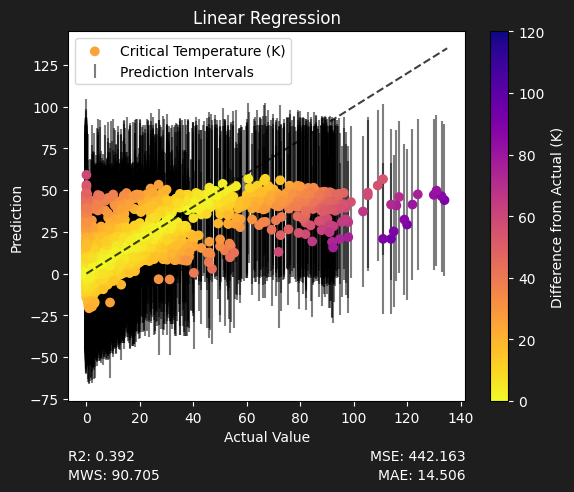

<Figure size 640x480 with 0 Axes>

In [3]:
sfn.import_data(replace_inf=True) #reimport data without infinities

sfn.evaluate_one("Linear Regression", LinearRegression, {}, uncertainty=True, method="plus")

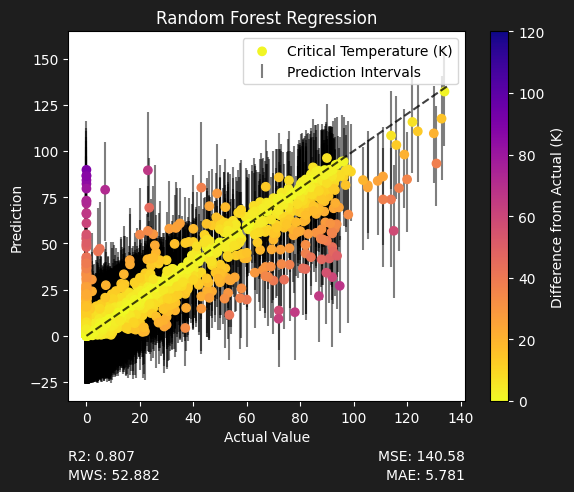

<Figure size 640x480 with 0 Axes>

In [4]:
sfn.import_data(replace_inf=True)
sfn.evaluate_one("Random Forest Regression", RandomForestRegressor, {}, uncertainty=True, method="plus") 
#compare with lolopy

In [5]:
sfn.import_data(replace_inf=True)
sfn.evaluate_one("Random Forest Regression - Optimized", RandomForestRegressor, {'max_features': 'auto', 'n_estimators': 300}, uncertainty=True, method="plus")
#compare with lolopy

#identify materials at zero (sample a few from data)

/home/sylphrena/anaconda3/envs/CLASSE/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/sylphrena/anaconda3/envs/CLASSE/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/sylphrena/anaconda3/envs/CLASSE/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/sylphrena/anaconda3/envs/CLASSE/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/sylphrena/anaconda3/envs/CLASSE/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/sylphrena

(2463,)


TypeError: '<=' not supported between instances of 'str' and 'float'

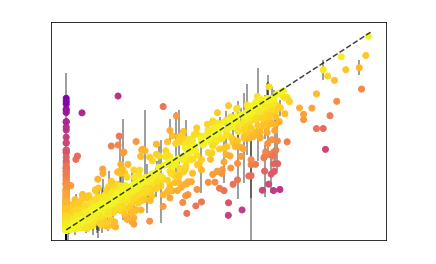

In [2]:
sfn.import_data(replace_inf=True)
sfn.evaluate_one("Random Forest Regression - ForestCI", RandomForestRegressor, {}, uncertainty=True, forestci=True) #NOTE: forestci calibration is disabled as there is a bug in the code (they use a too small datatype)
#compare with lolopy

In [ ]:
sfn.evaluate_one("Extra Trees - Optimized", ExtraTreesRegressor, {'n_estimators': 589}, uncertainty=True, method="plus")

## Bulk Results

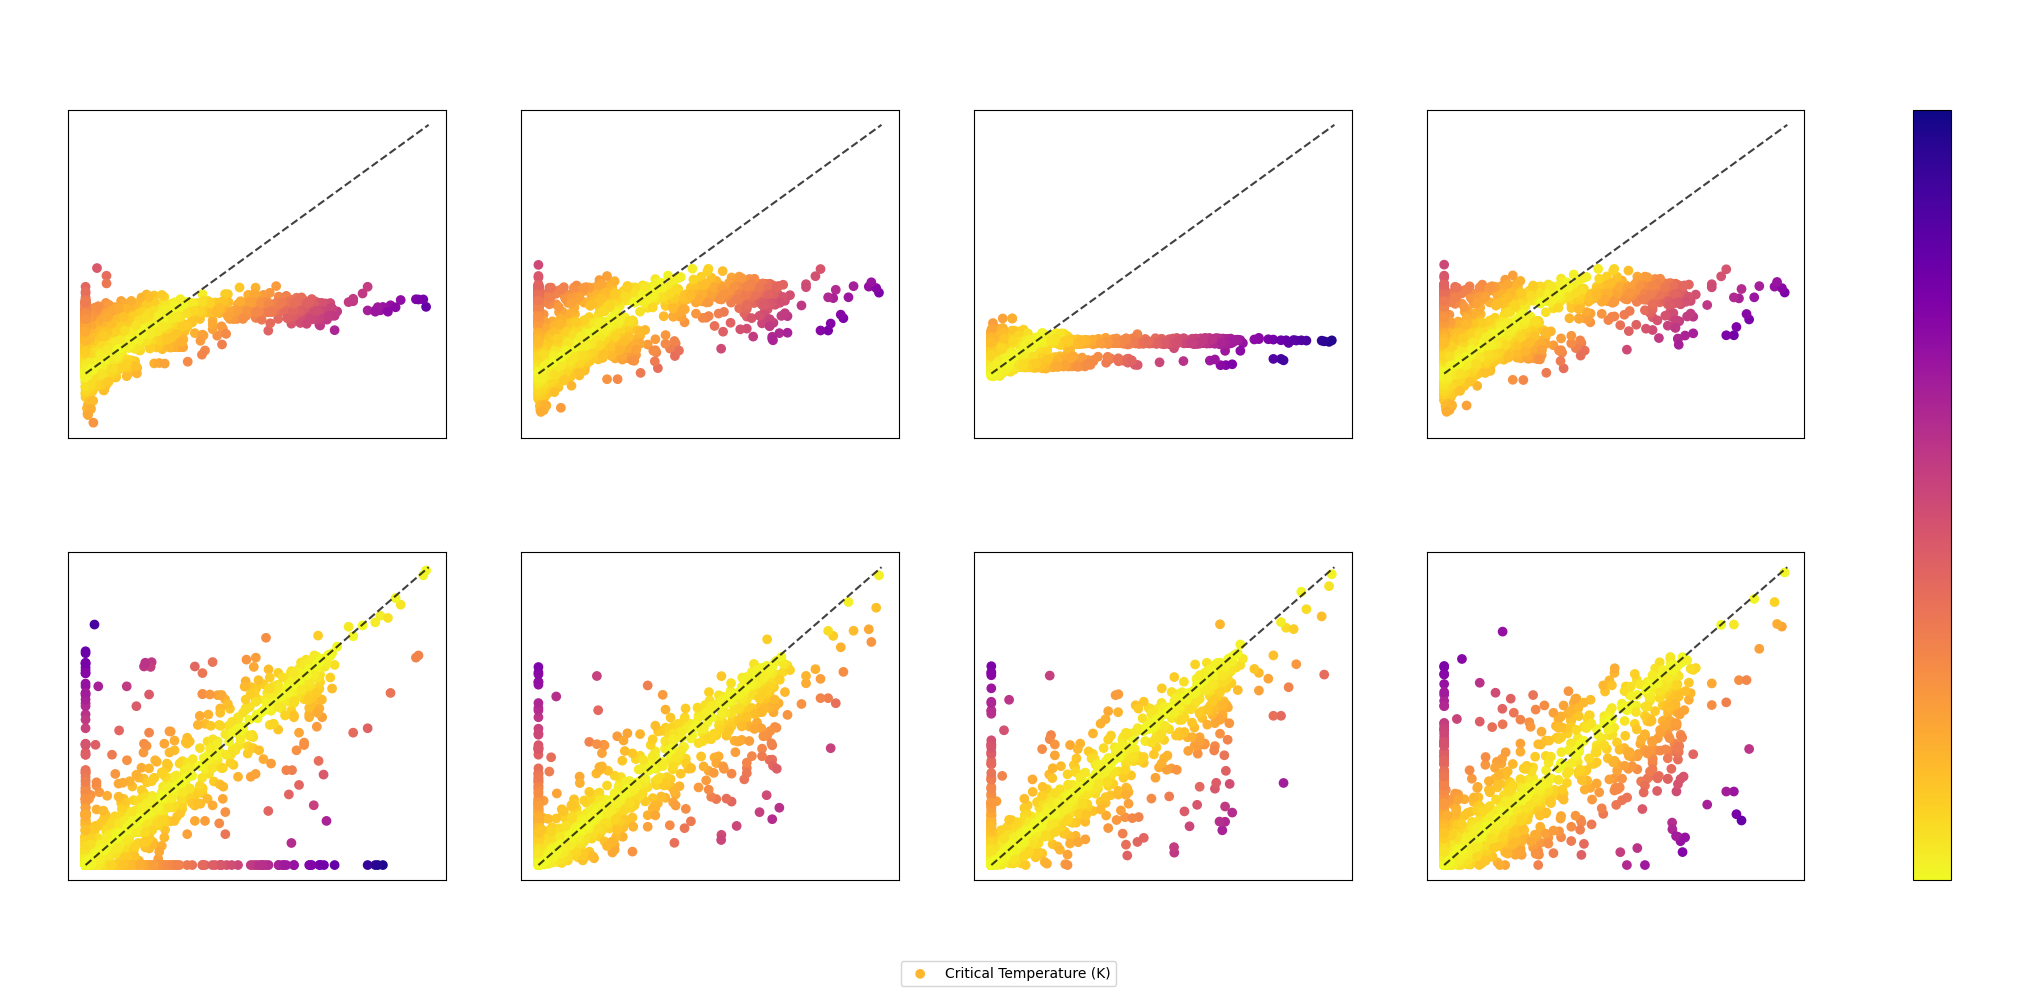

In [3]:
sfn.import_data(replace_inf=True)

#defines the models in a list of pairs of lists. The first item in a pair is the top graph in a column, the second is the bottom. The last item of a model is to enable error
models  =  ((("Elastic Net Regression", ElasticNet, {}, False),                 ("Decision Tree Regression", DecisionTreeRegressor, {}, False)),
            (("Bayesian Regression", BayesianRidge, {}, False),                 ("Random Forest Regression", RandomForestRegressor, {}, False)),
            (("Support Vector Machines", SVR, {}, False),                       ("Extra Trees Regression", ExtraTreesRegressor, {}, False)),
            (("Linear Regression", LinearRegression, {}, False),                ("KNeighbors Regression", KNeighborsRegressor, {}, False)))

#call the evaluation function
sfn.evaluate(models, title="Prediction vs. Actual Value (CV) - Unoptimized", filename="results_unoptimized.png", uncertainty=True) #call evaluation function

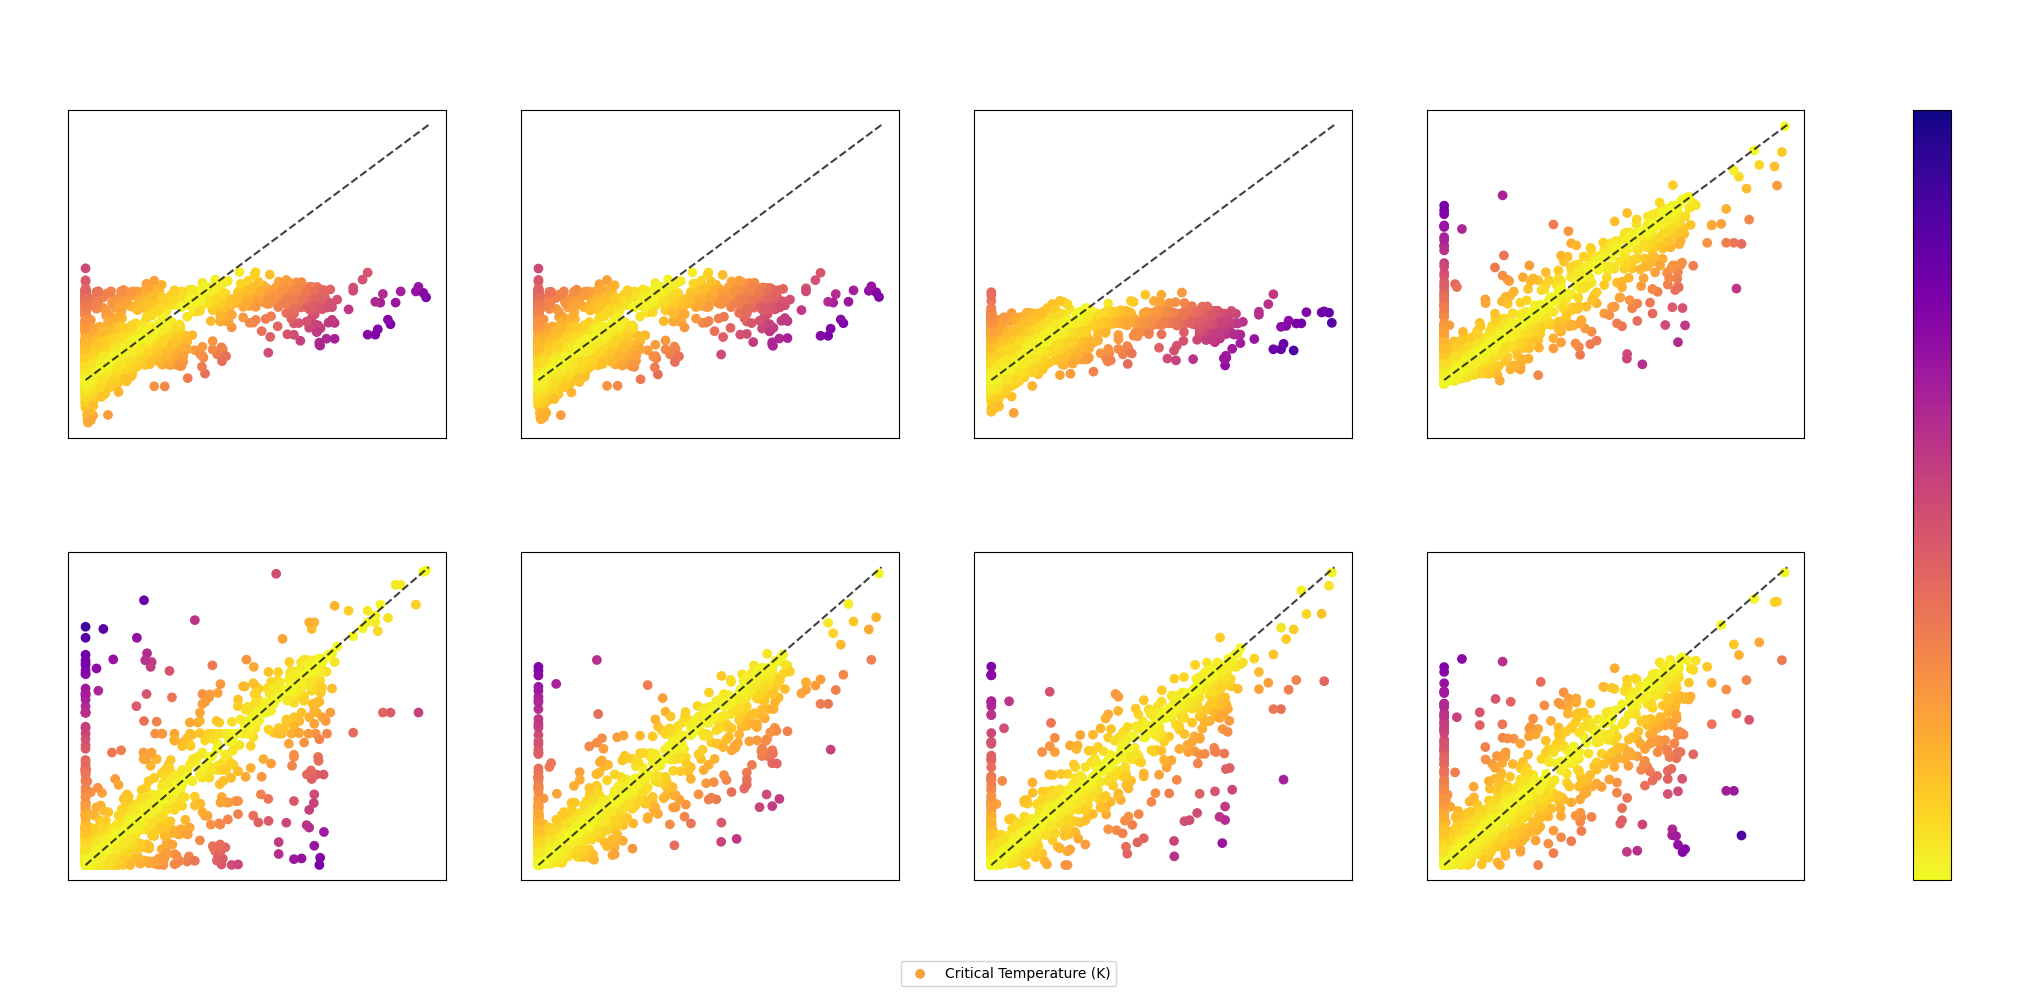

In [4]:
sfn.import_data(replace_inf=True)

#defines the optimized arguments for each model
ELASTIC_ARGS = {'alpha':1e-05, 'l1_ratio':0.0}
BAYES_ARGS = {}
SVR_ARGS = {'C':1, 'epsilon':10, 'gamma':'auto', 'kernel':'linear'}
RFR_ARGS = {}
SP_ARGS = {'X': sfn.train_data}
KNN_ARGS = {'metric':'manhattan', 'n_jobs':-1, 'n_neighbors':5}
DT_ARGS = {'criterion':'poisson', 'max_features':0.5, 'random_state':43}
TREES_ARGS = {}

sfn.import_data(replace_inf=True)
models  =  ((("Elastic Net Regression", ElasticNet, ELASTIC_ARGS, False),           ("Decision Tree Regression", DecisionTreeRegressor, DT_ARGS, False)),
            (("Bayesian Regression", BayesianRidge, BAYES_ARGS, False),             ("Random Forest Regression", RandomForestRegressor, RFR_ARGS, False)),
            (("Support Vector Machines", SVR, SVR_ARGS, False),                     ("Extra Trees Regression", ExtraTreesRegressor, TREES_ARGS, False)),
            (("Superlearner", Superlearner, SP_ARGS, False),                        ("KNeighbors Regression", KNeighborsRegressor, KNN_ARGS, False)))

sfn.evaluate(models, title="Prediction vs. Actual Value (CV) - Optimized", filename="results_optimized.png", uncertainty=True, forestci=False, method="plus")